### Analytically deriving the toy model and perturbation

$$
\text{As}\quad\vec{\nabla}\cdot\vec{B} = 0\quad\text{it get to}\quad\vec{B} = \vec{\nabla} \times \vec{A}\quad\text{thus with}\quad\vec{A} = (A_r, A_\phi, A_z)\\
$$
$$
\vec{B} = (-\partial_z A_\phi,\, \partial_z A_r - \partial_r A_z,\, 1/r\cdot\partial_z(r A_\phi))
$$

In [21]:
import sympy as sp
import numpy as np

In [23]:
r, phi, z, d, m, n, R, sf, shear = sp.symbols('r phi z d m n R sf shear', real=True, positive=True)
rr = sp.symbols('rr[0] rr[1] rr[2]')
I = sp.I  # Imaginary unit

replacement_dict = {r: rr[0], phi: rr[1], z: rr[2], I: 1j}

# Define b
b = sp.sqrt((R - r)**2 + z**2)

# Define Psi
Psi = b**2

# Define F
F = 2 * (sf + shear * b**2) * sp.sqrt(R**2 - b**2)

# Define the function
psi_mb = sp.sqrt(2/sp.pi) * (b**2/d**3) * sp.exp(-b**2/(2*d**2)) * ((r - R) + I*z)**m * sp.exp(I*n*phi)
psi_gaussian = (1/sp.sqrt(2*sp.pi*d**2)) * sp.exp(-b**2/(2*d**2)) * ((r - R) + I*z)**m * sp.exp(I*n*phi)

In [24]:
Psi

(R - r)**2 + (Z - z)**2

In [ ]:
sp.print_latex(psi_gaussian)

In [ ]:
psi_mb

In [ ]:
psi_gaussian

In [ ]:
B_equilibrium = sp.Matrix([-1/r * sp.diff(Psi, z), F/r, 1/r * sp.diff(Psi, r)])
B_equilibrium

In [ ]:
B_mb = sp.simplify(sp.re(sp.Matrix([-1/r * sp.diff(psi_mb, z), 0, 1/r * sp.diff(psi_mb, r)])))
B_gaussian = sp.simplify(sp.re(sp.Matrix([-1/r * sp.diff(psi_gaussian, z), 0, 1/r * sp.diff(psi_gaussian, r)])))

In [ ]:
sp.print_latex(sp.simplify(B_mb))

Transform the $\vec{B}$ expressions from `sympy` to actual functions

In [ ]:
temp1 = sp.lambdify((rr, R, sf, shear), B_equilibrium.subs(replacement_dict), 'numpy')
toroidal = lambda *args: np.squeeze(temp1(*args))

temp2 = sp.lambdify((rr, R, d, m, n), B_mb.subs(replacement_dict), 'numpy')
mb_perturbation = lambda *args: np.squeeze(temp2(*args))

temp3 = sp.lambdify((rr, R, d, m, n), B_gaussian.subs(replacement_dict), 'numpy')
gaussian_perturbation = lambda *args: np.squeeze(temp3(*args))

In [ ]:
B_equilibrium

Compute the jacobians

In [ ]:
grad_B_equilibrium = sp.zeros(3)

for i in range(3):
    grad_B_equilibrium[i, 0] = sp.diff(B_equilibrium[i], r)
    grad_B_equilibrium[i, 1] = 1/r * sp.diff(B_equilibrium[i], phi)
    grad_B_equilibrium[i, 2] = sp.diff(B_equilibrium[i], z)


grad_B_mb = sp.zeros(3)

for i in range(3):
    grad_B_mb[i, 0] = sp.diff(B_mb[i], r)
    grad_B_mb[i, 1] = 1/r * sp.diff(B_mb[i], phi)
    grad_B_mb[i, 2] = sp.diff(B_mb[i], z)

grad_B_gaussian = sp.zeros(3)

for i in range(3):
    grad_B_gaussian[i, 0] = sp.diff(B_gaussian[i], r)
    grad_B_gaussian[i, 1] = 1/r * sp.diff(B_gaussian[i], phi)
    grad_B_gaussian[i, 2] = sp.diff(B_gaussian[i], z)

In [ ]:
grad_B_equilibrium = sp.simplify(grad_B_equilibrium)
grad_B_mb = sp.simplify(grad_B_mb)
grad_B_gaussian = sp.simplify(grad_B_gaussian)

#### Printing in python format

In [ ]:
sp.printing.python(B_gaussian.subs(replacement_dict))

### Showing the question

In [4]:
ps = AnalyticCylindricalBfield(1, 0.91, 0.7, [])

In [5]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-7

# set up the Poincare plot
pparams = dict()
pparams["Rbegin"] = 1.01
pparams["Rend"] = 1.99
pparams["nPtrj"] = 20
pparams["nPpts"] = 150
pparams["zeta"] = 0

# Set RZs
nfieldlines = pparams["nPtrj"]+1
Rs = np.linspace(3, 3.75, nfieldlines)
Zs = np.linspace(0., 0., nfieldlines)
RZs = np.array([[r, z] for r, z in zip(Rs, Zs)])

pplot = PoincarePlot(ps, pparams, integrator_params=iparams)
# pdata = pplot.compute(RZs)
pdata = pplot.compute()

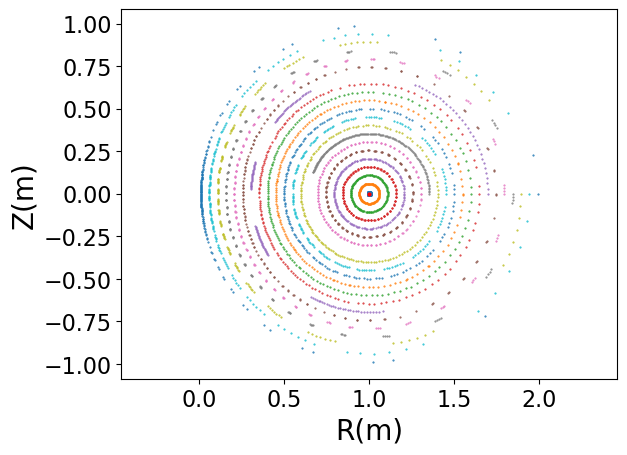

In [7]:
pplot.plot(marker=".", s=1)
# plt.xlim(2.6, 3.5)
plt.scatter(ps._R0, 0, color="r", s=4)
fig = plt.gcf()

In [ ]:
pplot.plot(marker=".", s=1)
# plt.xlim(2.6, 3.5)
plt.scatter(ps._R0, 0, color="r", s=4)
fig = plt.gcf()

### Numerical adventure

In [8]:
from pyoculus.problems import CylindricalBfield
from pyoculus.solvers import PoincarePlot
import matplotlib.pyplot as plt
import numpy as np

In [9]:
import sys
import os
sys.path.append('..')

from toybox import *

In [10]:
pert_1 = {"m": 1, "n": -1, "d": 1, "type": "maxwell-boltzmann", "amplitude": 0.01}
pert_2 = {"m": 1, "n": 0, "d": 1, "type": "gaussian", "amplitude": -1.5}

ps = AnalyticCylindricalBfield(3, 0.91, 0.7, [pert_1])

In [11]:
%timeit ps.B_perturbation([3., 0., 0.])

9.17 µs ± 557 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
%timeit ps.B_equilibrium([3., 0., 0.])

12.1 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [13]:
%timeit ps.B([3., 0., 0.])

27.5 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


(<Figure size 2000x500 with 8 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

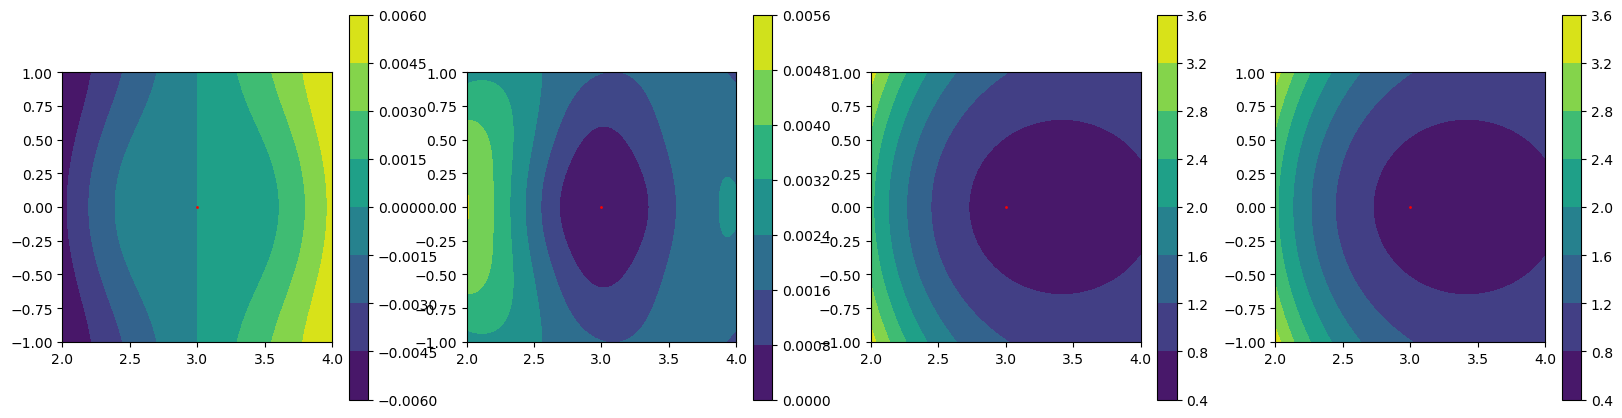

In [14]:
plot_intensities(ps, [2,4], [-1,1])

In [15]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-7

# set up the Poincare plot
pparams = dict()
pparams["Rbegin"] = 2.6
pparams["Rend"] = 3.7
pparams["nPtrj"] = 20
pparams["nPpts"] = 150
pparams["zeta"] = 0

# Set RZs
nfieldlines = pparams["nPtrj"]+1
Rs = np.linspace(3, 3.75, nfieldlines)
Zs = np.linspace(0., 0., nfieldlines)
RZs = np.array([[r, z] for r, z in zip(Rs, Zs)])

pplot = PoincarePlot(ps, pparams, integrator_params=iparams)
# pdata = pplot.compute(RZs)
pdata = pplot.compute()

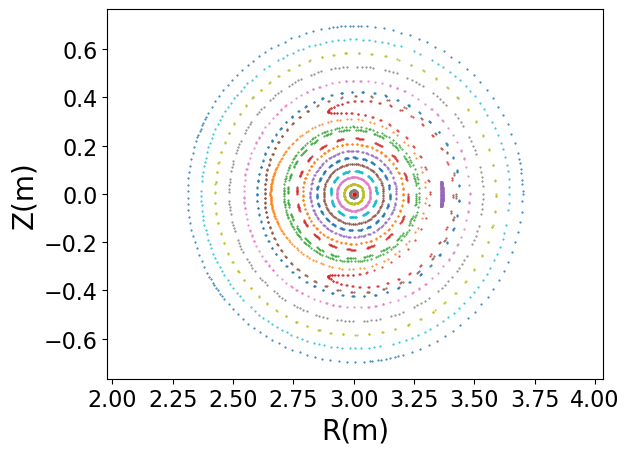

In [16]:
pplot.plot(marker=".", s=1)
# plt.xlim(2.6, 3.5)
plt.scatter(ps._R0, 0, color="r", s=4)
fig = plt.gcf()

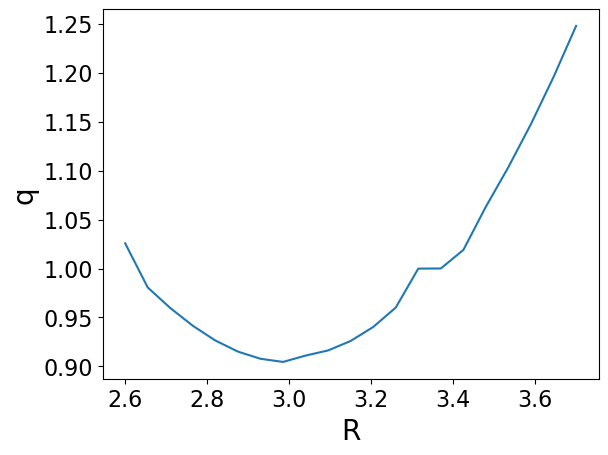

In [17]:
pplot.compute_iota()
pplot.plot_q()

# plt.hlines(np.abs(ps.perturbation_args['m']/ps.perturbation_args['n']), 3, 4, color="k", linestyle="--")
# plt.hlines(ps._n/ps._m, 3, 3.7, color="k", linestyle="--")

# rho = np.linspace(3.001, 3.7, 20)
# q=ps._sf+ps._shear*(ps._R0-rho)**2

# plt.plot(rho, q, color="orange", linestyle="--")

In [ ]:
ps.amplitudes

In [ ]:
ps.perturbations[0]([1,1,1])

In [ ]:
ps.add_perturbation(pert_2)

In [ ]:
ps.amplitudes = [0.22, -0.6]

In [ ]:
ps.amplitudes

In [ ]:
# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-7

# set up the Poincare plot
pparams = dict()
pparams["Rbegin"] = 2.6
pparams["Rend"] = 4.05
pparams["nPtrj"] = 20
pparams["nPpts"] = 150
pparams["zeta"] = 0


pplot = PoincarePlot(ps, pparams, integrator_params=iparams)
pdata = pplot.compute()

In [ ]:
pplot.plot(marker=".", s=1)
# plt.xlim(2.6, 3.5)
plt.scatter(ps._R0, 0, color="r", s=4)
fig = plt.gcf()

In [ ]:
pplot.compute_iota()
pplot.plot_q()

### Finding fixed points

In [18]:
from pyoculus.solvers import FixedPoint

# set up the integrator
iparams = dict()
iparams["rtol"] = 1e-22

pparams = dict()
pparams["nrestart"] = 0
pparams['niter'] = 300

fp = FixedPoint(ps, pparams, integrator_params=iparams)

# fp.compute(guess=[3.5, 0], pp=1, qq=2, sbegin=2, send=4, tol = 1e-12)
fp.compute(guess=[3.4, 0.], pp=1, qq=1, sbegin=2, send=4, tol = 1e-10)

0 - dr : 0.05022539957468124 - dtheta : 0.12567596958302474
1 - RZ : [ 3.36742124e+00 -2.66876442e-03] - rhotheta : [ 0.36743093 -0.00726337]
1 - dr : 0.0016396110257693166 - dtheta : 0.004461953758865563
2 - RZ : [ 3.36618477e+00 -7.84252958e-06] - rhotheta : [ 3.66184775e-01 -2.14168642e-05]
2 - dr : 1.5322387006784356e-05 - dtheta : 4.184211160313592e-05
3 - RZ : [ 3.36617302e+00 -3.65808157e-10] - rhotheta : [ 3.66173024e-01 -9.99003568e-10]
3 - dr : 3.3685130378104365e-10 - dtheta : 9.198401821646754e-10
4 - RZ : [3.36617302e+00 9.74698891e-11] - rhotheta : [3.66173023e-01 2.66185336e-10]
4 - dr : 2.569656676725361e-15 - dtheta : 4.4803726913443746e-15


In [19]:
results = [list(p) for p in zip(fp.x, fp.y, fp.z)]
results

[[3.3661730233547402, 0.0, 9.746988907561667e-11],
 [3.3661730233547416, 0.0, 9.747208639179772e-11]]

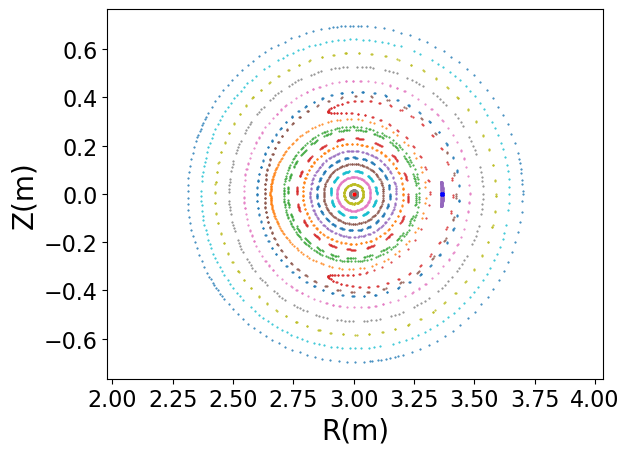

In [20]:
ax = fig.get_axes()[0]
ax.scatter(results[0][0], results[0][2], color="b", s=5, marker="X") 
ax.scatter(results[1][0], results[1][2], color="b", s=5, marker="X")
fig

## with ivp

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
def integrate_ivp(Bfield_2D, RZstart, phis, **kwargs):
    options = {
        "rtol": 1e-7,
        "atol": 1e-9,
        "nintersect": 400,
        "method": "DOP853",
        "direction": 1,
        "m": 1,
        "nfp": 1,
    }
    options.update(kwargs)

    assert RZstart.shape[1] == 2, "RZstart must be a 2D array with shape (n, 2)"
    assert len(phis) > 0, "phis must be a list of floats with at least one element"
    assert isinstance(options["nintersect"], int) and options["nintersect"] > 0, "nintersect must be a positive integer"
    assert options["direction"] in [-1, 1], "direction must be either -1 or 1"
    
    # setup the phis of the poincare sections
    phis = np.unique(np.mod(phis, 2 * np.pi / options['nfp']))
    phis.sort()

    # setup the evaluation points for those sections
    phi_evals = np.array(
        [
            phis + options['m'] * 2 * np.pi * i / options['nfp']
            for i in range(options["nintersect"] + 1)
        ]
    )

    out = solve_ivp(
        Bfield_2D,
        [0, phi_evals[-1, -1]],
        RZstart.flatten(),
        t_eval=phi_evals.flatten(),
        method=options["method"],
        atol=options["atol"],
        rtol=options["rtol"],
    )

    return out

In [ ]:
def Bfield_2D(t, rzs, direction = 1):
    rzs = rzs.reshape((-1, 2))
    phis = direction*(t % (2 * np.pi)) * np.ones(rzs.shape[0])
    Bs = np.array([ps.B([rzs[i, 0], phis[i], rzs[i, 1]]) for i in range(len(rzs))])

    return np.array([Bs[:,0]/Bs[:,1], Bs[:,2]/Bs[:,1]]).T.flatten()

In [ ]:
nfieldlines = 1
Rs = np.linspace(3, 3, nfieldlines)
Zs = np.linspace(0.01, 0.5, nfieldlines)
RZs = np.array([[r, z] for r, z in zip(Rs, Zs)])

In [ ]:
out = integrate_ivp(Bfield_2D, RZs, [0])

In [ ]:
ys = out.y.reshape(nfieldlines, 2, -1)
for yy in ys:
    plt.scatter(yy[0, :], yy[1, :], s=10, marker=".")

## The tokamap

In [ ]:
def P(psi, theta, K):
    return psi - 1 - K/(2*np.pi) * np.sin(2*np.pi*theta)

def W(psi, w):
    return w/4*(2-psi)*(2-2*psi+psi**2)

In [ ]:
def tokamap(psi, theta, K, w):
    p = P(psi, theta, K)
    psi_evolved = 0.5*(p + np.sqrt(p**2 + 4*psi))
    theta_evolved = theta + W(psi_evolved, w) - K/((2*np.pi)**2)/((1+psi_evolved)**2)*np.cos(2*np.pi*theta)
    return np.array([
        psi_evolved,
        theta_evolved % 1
    ])

In [ ]:
x = np.array([0., 0.5])

In [ ]:
x = tokamap(x[0], x[1], 3.7, 1.)
print(x)

In [ ]:
xi = np.linspace(0, 1, 7)
Xi = np.meshgrid(xi, xi)
Xi = np.array(Xi).reshape(2, -1)

In [ ]:
nev = 1000
Ev = np.empty((Xi.shape[0], Xi.shape[1], nev))

In [ ]:
K = 3.7
w = 1.0

for i, x in enumerate(Xi.T):
    Ev[:, i, 0] = x
    xt = x.copy()
    for j in range(nev-1):
        xt = tokamap(xt[0], xt[1], K, w)
        Ev[:, i, j+1] = xt

In [ ]:
for i in range(len(Ev[0,:,0])):
    plt.scatter(Ev[1, i, :], Ev[0, i, :], s=0.5, alpha=0.5)